# Heat equation - Retrieving operator through ODE solving

In [139]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint as odeint

Simple graphic tools

In [108]:
def simple_plotter(ks, title='Simple plot', L=1.0):
    """
    Graphic tool to plot simple values
    """
    fig, ax = plt.subplots()
    fig.tight_layout()
    plt.title(title)
    # 
    for k in ks:
        x = np.linspace(0, L, len(k))
        ax.plot(x, k)
    
    plt.show()

In [106]:
def show_state(a, title):
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    plt.colorbar(im);
    plt.xlabel('x');
    plt.ylabel('t');
    plt.title(title)

## Analytical solution

Compute the analytical solution u(t, x)

In [4]:
def analytical_heat_1d(t, x, n_max: int=1, rand=False):
    """
    Analytical solution to 1D heat equation.
    Return solution for a tuple (t, x)
    """
    L = 1.
    
    cn = np.ones(n_max)
    if rand:
        cn = np.random.rand(n_max)
    
    u = np.sum([cn[n] * np.exp((-np.pi**2 * n**2 * t) / L) * np.sin((n * np.pi * x) / L) for n in range(n_max)], axis=0)
    return u, cn

In [5]:
def get_heat(t_max, t_min, x_max, x_min, t_n, x_n, rand=False):
    """
    Compute heat equation solution values for a set of (t, x) tuples.
    """
    t_axis = np.linspace(t_min, t_max, t_n)
    x_axis = np.linspace(x_min, x_max, x_n)
    
    return analytical_heat_1d(t_axis[:, None], x_axis[None, :], 50, rand)

Compute the analytical derivative by time of the solution u(t,x)

In [6]:
def analytical_grad_t_heat_1d_t(t, x, cn=None, n_max=1):
    """
    Analytical gradient by t of the solution to 1D heat equation
    Return value for a tuple (t, x)
    """
    
    if cn is None:
        cn = np.ones(n_max)
        
    return np.sum([-np.pi**2 * n**2 * np.exp(-np.pi**2 * n**2 * t) * np.sin(n * np.pi * x) for n in range(n_max)], axis=0)

In [7]:
def get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n, cn=None):
    """
    Compute gradient by t to heat equation solution values for a set of (t, x) tuples.
    """
    t_axis = np.linspace(t_min, t_max, t_n)
    x_axis = np.linspace(x_min, x_max, x_n)
    
    return analytical_grad_t_heat_1d_t(t_axis[:, None], x_axis[None, :], cn, 10)

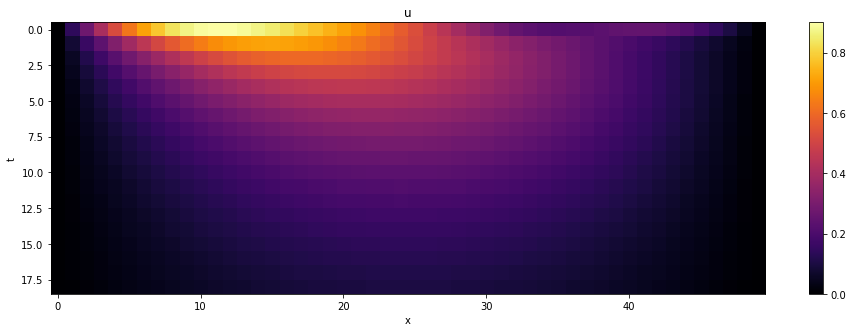

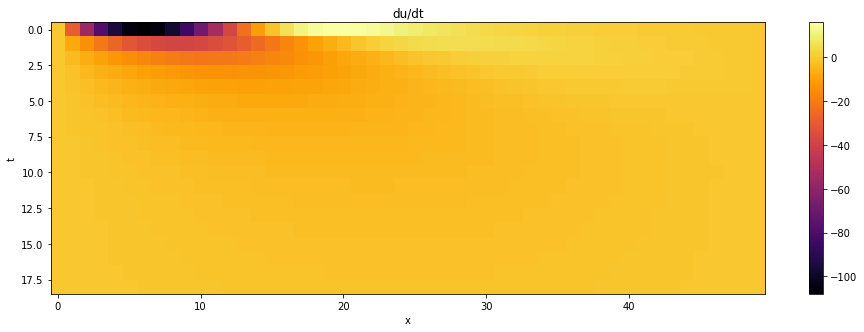

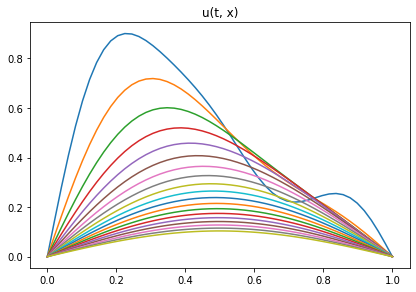

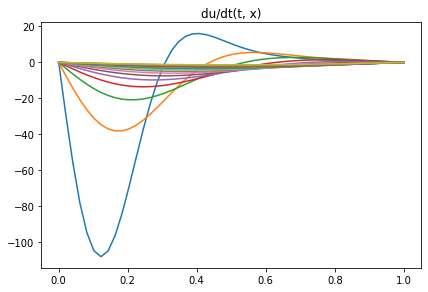

In [362]:
u_true, cn = get_heat(0.2, 0., 1., 0., 20, 50, True)
g_u_true = get_heat_grad_t(0.2, 0., 1., 0., 20, 50, cn)

show_state(u_true[1:], 'u')
show_state(g_u_true[1:], 'du/dt')

simple_plotter(u_true[1:], 'u(t, x)')
simple_plotter(g_u_true[1:], 'du/dt(t, x)') 

---

## Get operator F

### Definition of Model used by ODE solver

In [320]:
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Sigmoid(),
            nn.Linear(50, 2)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Implementation of the neural ODE

Let's now write our neural ODE. In a first time we will generate some data and
process them in a format usable by PyTorch and the ODESolver (torchdiffeq).

In [409]:
def get_batch(t_max, x_max, t_n, x_n, x_batch_size, rand=True):
    # We generate our time and space axis
    t_range = np.linspace(0., t_max, t_n)[1:]
    x_range = np.linspace(0., x_max, x_n)
    
    # Then compute a snapshot of the solution u(t, x).
    u, _ = get_heat(t_max, 0.0, x_max, 0.0, t_n, x_n, rand)
    u_t = torch.from_numpy(u[1:,:]).float() # Convert to Tensor
    # Select random indexes for our training batch
    rand_idx = np.random.choice(np.arange(x_n, dtype=np.int64), x_batch_size, replace=False)
    rand_idx = np.sort(rand_idx)
    # Get the values from the x-axis and the solution u(0, x)
    batch_x0 = torch.from_numpy(x_range[rand_idx]).float()[:, np.newaxis]
    batch_u0 = u_t[0, rand_idx, np.newaxis]  # Get u(0, x)
    # Concatenate x and u0 values = dimension (x_batch_size, 2)
    batch_xu0 = torch.cat((batch_x0, batch_u0), 1)

    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range).float()
    
    # Get the values of u for each instant t of the batch_t
    batch_u = torch.stack([u_t[i, rand_idx] for i in range(0, t_n - 1)], dim=0)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    batch_x = torch.from_numpy(x_range[rand_idx]).float().repeat(t_n - 1, 1)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    
    # Concatenate x and u values.  dimension (t_max, x_batch_size, 2)
    batch_xu = torch.cat((batch_x, batch_u), 2)
    
    return batch_t, batch_xu0, batch_xu

In [410]:
t, b0, by = get_batch(0.2, 1., 10, 10, 5, False)
print(t.size())
print(b0.size())
print(by.size())

torch.Size([9])
torch.Size([5, 2])
torch.Size([9, 5, 2])


Let's write a small training loop for our neural ode.

In [411]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10):
    loss_fn = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.003)

    for e in range(1, epochs + 1):
        loss_tot = 0
        for i in range(int(x_n / batch_size)):
            optimizer.zero_grad()
            
            t, b0, bu = get_batch(1., 1., t_n, x_n, batch_size)
            pred_u = odeint(net, b0, t)  # net = F
            #loss = torch.mean(torch.square(pred_u[:,:,0] - bu[:,:,0])) + torch.mean(torch.square(pred_u[:,:,1] - bu[:,:,1])) # loss_fn(pred_u, u_true)
            
            loss1 = loss_fn(pred_u[:,:,0], bu[:,:,0]) 
            loss2 = loss_fn(pred_u[:,:,1], bu[:,:,1])
            loss = loss1 + loss2
            loss_tot += loss.item()
            loss.backward(retain_graph=True)
            
            optimizer.step()
        
        if e % 10 == 0:
            t, b0, bu = get_batch(1., 1., t_n, x_n, x_n)
            visualize_u_from_F(net, t, b0)
            print('epoch %d f loss %f'%(e, float(loss_tot / float(x_n / batch_size))))
            
    return net

epoch 10 f loss 0.051986
epoch 20 f loss 0.017703
epoch 30 f loss 0.002992
epoch 40 f loss 0.012336
epoch 50 f loss 0.005216
epoch 60 f loss 0.011899


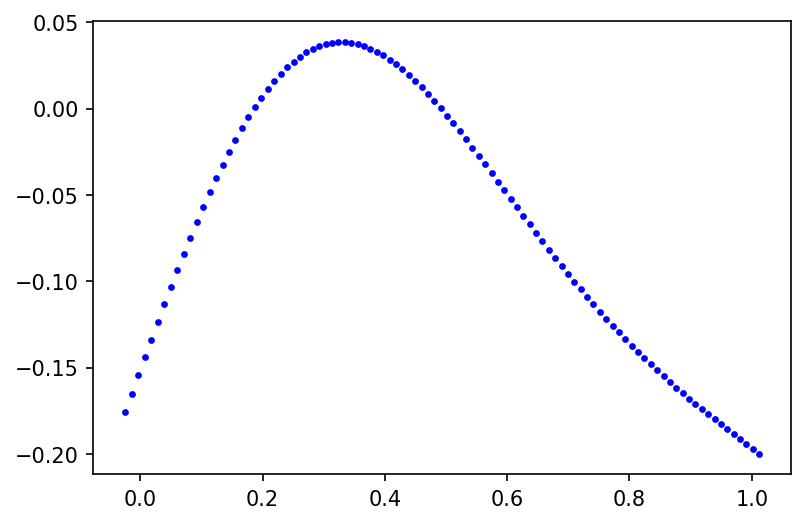

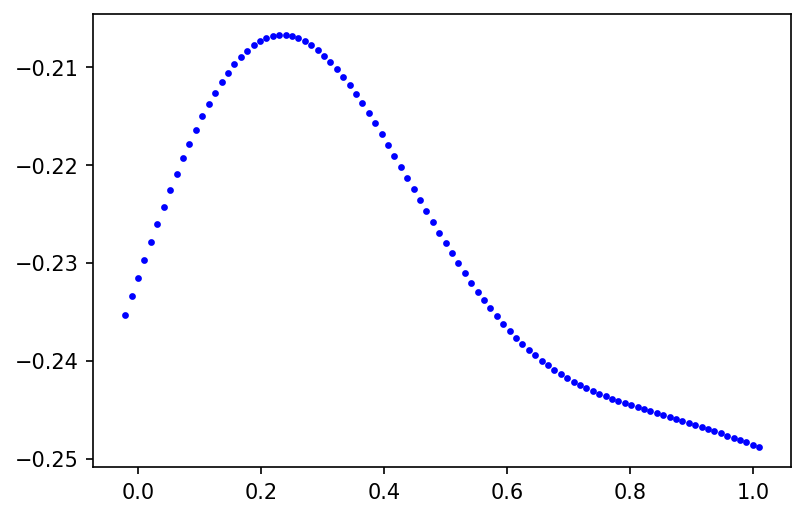

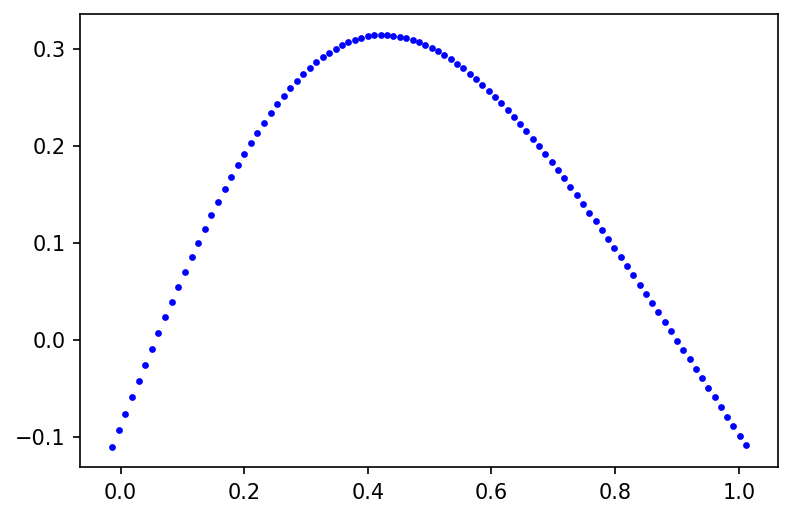

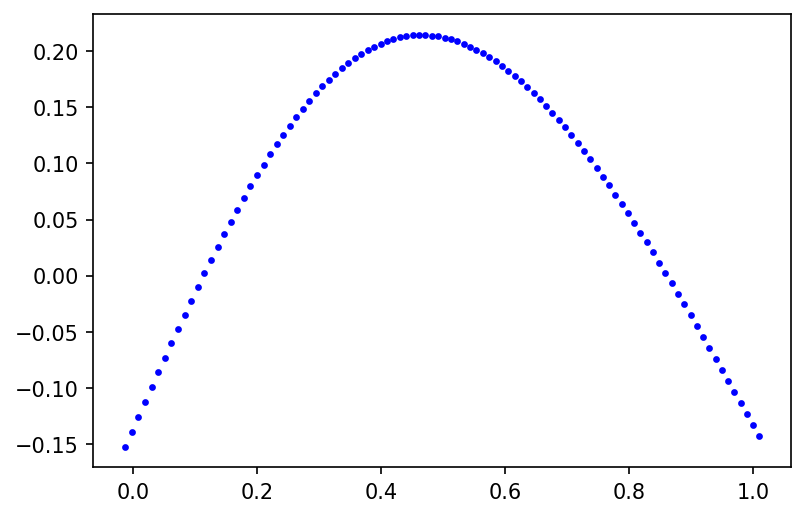

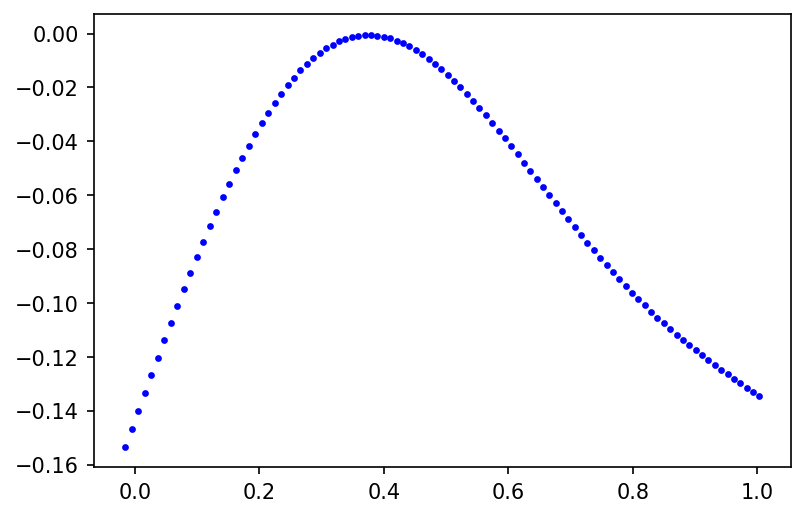

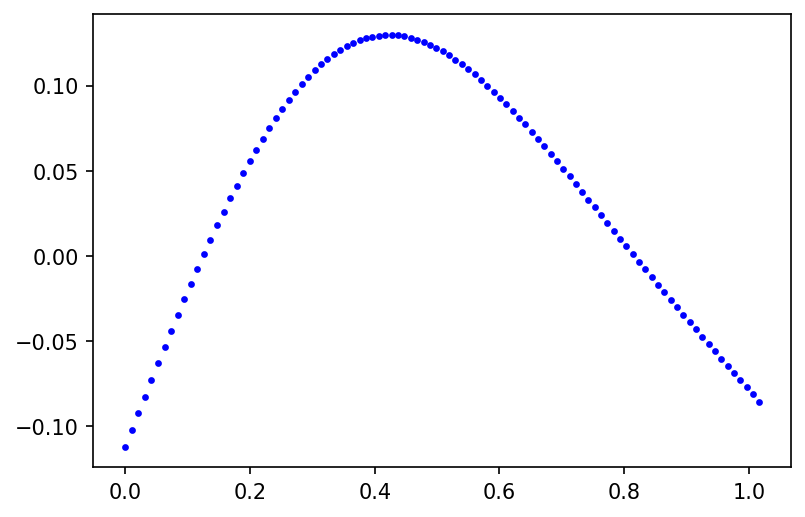

In [412]:
net = ODEModel()
F = training_ode_solver_net(net, 60, 20, 100, 50)

## Visualization

In [465]:
def visualize_F_with_u(F, t_n=20, x_n=100):
    u, x = np.mgrid[-0.2:0.2:10j, 0.:1.:10j]
    grid_xu = torch.from_numpy(np.stack([x, u], -1).reshape(x_n * x_n, 2)).float()
    t = torch.Tensor(np.linspace(0., 1.0, t_n))
    u_m = np.zeros((t_n, x_n * x_n, 2))

    for i in range(1, t_n):
        tmp = F(0, grid_xu).detach().numpy()
        u_m[i] = tmp
    
    color = ['b','r','g','y']
    width=200
    height=150
    
    for i in [5]: # range(1, t_n, 5):
        xlims = (u_m[i, :, 0].min(), u_m[i, :, 0].max())
        ylims = (u_m[i, :, 1].min(), u_m[i, :, 1].max())
        dx = xlims[1] - xlims[0]
        dy = ylims[1] - ylims[0]
        
        buffer = np.zeros((height+1, width+1))
        
        for j, p in enumerate(u_m[i, :, :]):
            x0 = int(round(((p[0] - xlims[0]) / dx) * width))
            y0 = int(round((1 - (p[1] - ylims[0]) / dy) * height))
            buffer[y0, x0] += 0.3
            if buffer[y0, x0] > 1.0: buffer[y0, x0] = 1.0
        
        ax_extent = list(xlims)+list(ylims)
        plt.figure(dpi=150)
        plt.imshow(
            buffer,
            vmin=0,
            vmax=1, 
            cmap=plt.get_cmap('hot'),
            interpolation='lanczos',
            aspect='auto',
            extent=ax_extent)
            
    return u_m

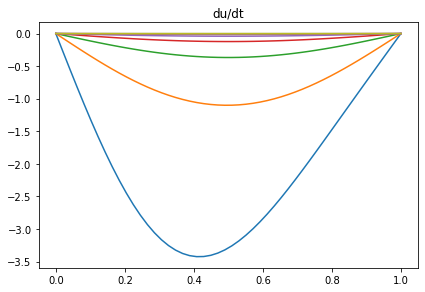

In [467]:
# W compute u(t,x) to use the same set of constants c for du/dt.
u, cn = get_heat(1., 0., 1., 0., 20, 50, True)
g_u = get_heat_grad_t(1.0, 0.0, 1.0, 0.0, 10, 50, cn)[1:]
simple_plotter(g_u, 'du/dt')
# test = visualize_F_with_u(F, 20, 10)

What is happening here ?
We display du/dt for a set of grid points (t, x) to have an overall idea of the derivative shape.
With the operator F, we provide a different set of values, has we generate grid points (x, u).
While the results will be different, it clearly apppears we do not get the same shapes.


In [415]:
def visualize_u_from_F(F, t, u0): # t_n, x_n, t_max, x_max, t_idx=0:
    plt.figure(dpi=150)
    pred_u = odeint(F, u0, t).detach().numpy()
    color = ['b','r','g','y']
    i = t.shape[0] - 1
    
    #plt.plot(pred_u[:, :, 0], pred_u[:, :, 1], 'b--')
        
    for j in range(int(len(pred_u[i]))):
        zx = pred_u[i,j,0]
        zu = pred_u[i,j,1]
        plt.scatter(zx, zu, s=5, c='b')

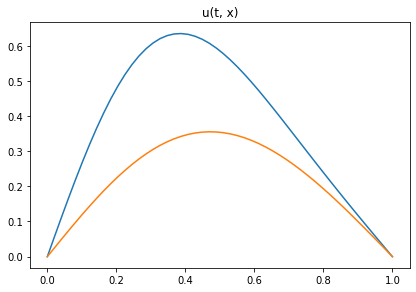

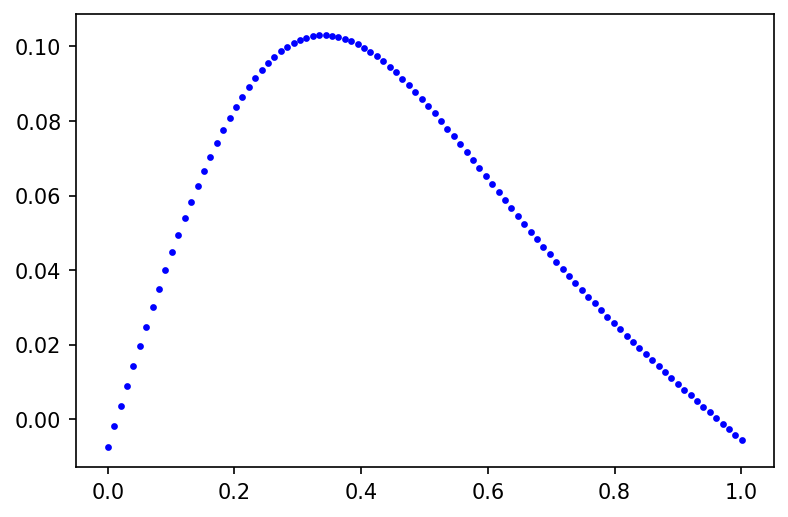

In [470]:
u_true, cn = get_heat(1., 0., 1., 0., 20, 50, False)
simple_plotter(u_true[1:3], 'u(t, x)')

t, u0, _ = get_batch(1., 1., 20, 100, 100)          
visualize_u_from_F(F, t[1:3], u0) #  20, 100, 1., 1., 19

---

## Results analysis

As the earlier visualization offers some results which appears to be different from the expected values, we perform some errors analysis.

In [ ]:
def analyze_error(F, u, g_u):
    return np.mean(np.abs(F @ u - g_u))